In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
import shutil
import os
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
from tqdm import tqdm
import seaborn as sns
from scipy.spatial import ConvexHull

### Graph all nuclei within z range and by type

In [2]:
def filter_and_graph_nuclei_distribution(df, z_1=280, z_2=1950):
    df_nuclei_zfilter = df_nuclei[(df_nuclei['z'] >= z_1) & (df_nuclei['z'] <= z_2)]
    df_nuclei_zfilter_pyr = df_nuclei_zfilter[df_nuclei_zfilter['group'] == 'pyr']
    df_nuclei_zfilter_inh = df_nuclei_zfilter[df_nuclei_zfilter['group'] == 'inh']
    df_nuclei_zfilter_all_others = df_nuclei_zfilter[(df_nuclei_zfilter['group'] != 'inh') & (df_nuclei_zfilter['group'] != 'pyr')]

    # Define bold colors
    bold_blue = "#1E90FF"   # Dodger Blue
    bold_orange = "#FF8C00" # Dark Orange
    bold_red = "#DC143C"    # Crimson

    # --- Create and save the histogram separately ---
    plt.figure(figsize=(10, 8))
    plt.hist(df_nuclei_zfilter_all_others['size_um3'], bins=50, color=bold_blue, alpha=0.6, label='All Others', edgecolor='black')
    plt.hist(df_nuclei_zfilter_pyr['size_um3'], bins=50, color=bold_orange, alpha=0.6, label='Pyr', edgecolor='black')
    plt.hist(df_nuclei_zfilter_inh['size_um3'], bins=50, color=bold_red, alpha=0.6, label='Inh', edgecolor='black')

    plt.yscale('log')
    plt.legend()
    plt.xlabel('Size (um³)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Nuclei Sizes')

    # Save histogram
    plt.savefig('Histogram_NucleiSize_LogScale.png', dpi=600)
    plt.show()

    # --- Create and save the scatter plot separately ---
    plt.figure(figsize=(7, 8))
    plt.scatter(df_nuclei_zfilter_all_others['x'], df_nuclei_zfilter_all_others['y'], color=bold_blue, s=3, alpha=0.5, label='All Others')
    plt.scatter(df_nuclei_zfilter_pyr['x'], df_nuclei_zfilter_pyr['y'], color=bold_orange, s=5, alpha=1, label='Pyr')
    plt.scatter(df_nuclei_zfilter_inh['x'], df_nuclei_zfilter_inh['y'], color=bold_red, s=7, alpha=1, label='Inh')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.title('Scatter Plot of Nuclei Locations')

    # Save scatter plot
    plt.savefig('Scatterplot_NucleiSize.png', dpi=600)
    plt.show()
    
    return df_nuclei_zfilter, df_nuclei_zfilter_pyr, df_nuclei_zfilter_inh, df_nuclei_zfilter_all_others

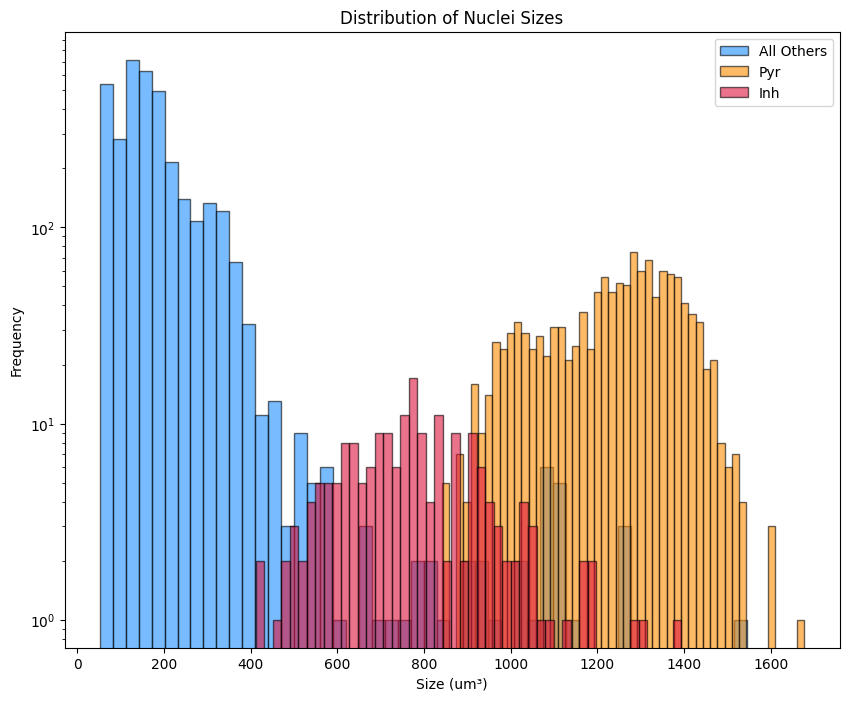

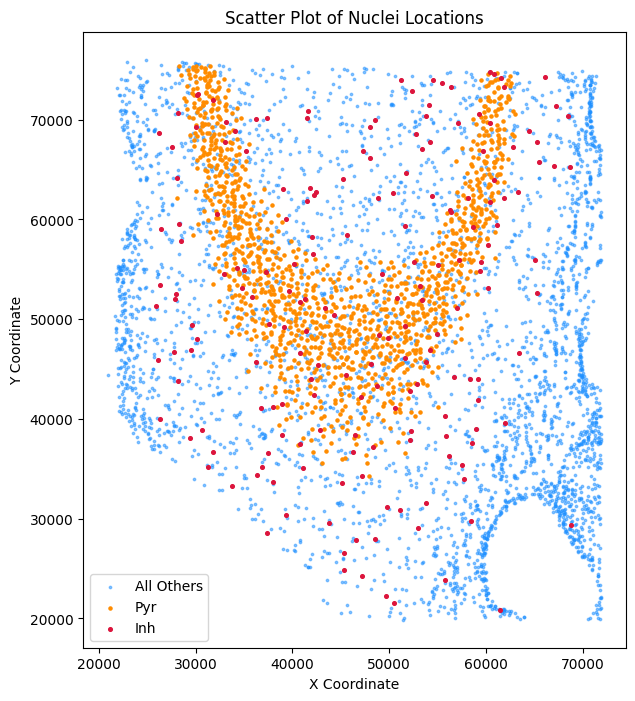

(      anacon  nucleus_index      nucleus segid      x      y     z    size  \
 0        414           2623  72198950068682855  26320  40032   418  242573   
 1        451           2714  72199156629766317  26144  45904  1915  233890   
 2        469           2779  72199362385543250  25936  51312   366  221583   
 3        480           2804  72199431440564319  26288  53440  1791  242947   
 4        498           2849  72199637598994586  26400  59088  1557  172237   
 ...      ...            ...                ...    ...    ...   ...     ...   
 6569    6569          35482  73818324672184330  71632  65056   790   43724   
 6570    6570          35487  73818324806402051  71680  66144  1447   38660   
 6571    6571          35493  73818393458770060  71616  67168  1276   19164   
 6572    6572          35494  73818393525878895  71824  66992  1572   30475   
 6573    6573          35496  73818393592987864  71600  67424  1769   48661   
 
         supervoxel group    segid_0217    size_um

In [4]:
df_nuclei = pd.read_csv('nuclei_table_250217 - nuclei.csv')
filter_and_graph_nuclei_distribution(df_nuclei)

### Graph Thorny vs. Athorny Cells

In [18]:
def filter_and_graph_pyr_cells(df, graph=True, z_1=1600, z_2=1950, mf_filter=10, outlier_filter=950):
    df_nuclei_pyr_thorny_a = df[(df['z'] >= z_1) & (df['z'] <= z_2)]

    df_nuclei_pyr_thorny = df_nuclei_pyr_thorny_a[df_nuclei_pyr_thorny_a['GT_numMF'] >= mf_filter]
    df_nuclei_pyr_athorny = df_nuclei_pyr_thorny_a[df_nuclei_pyr_thorny_a['GT_numMF'] < mf_filter]

    df_nuclei_pyr_thorny = df_nuclei_pyr_thorny[df_nuclei_pyr_thorny['size_um3'] > outlier_filter]
    df_nuclei_pyr_athorny = df_nuclei_pyr_athorny[df_nuclei_pyr_athorny['size_um3'] > outlier_filter]
    
    df_nuclei_pyr_athorny_1 = df_nuclei_pyr_athorny[df_nuclei_pyr_athorny['size_um3'] <= 1200]
    df_nuclei_pyr_athorny_2 = df_nuclei_pyr_athorny[df_nuclei_pyr_athorny['size_um3'] > 1200]
    
    df_nuclei_pyr_thorny_1 = df_nuclei_pyr_thorny[df_nuclei_pyr_thorny['size_um3'] <= 1200]
    df_nuclei_pyr_thorny_2 = df_nuclei_pyr_thorny[df_nuclei_pyr_thorny['size_um3'] > 1200]
    
    df_nuclei_pyr_thorny.to_csv('large_thorny_for_top10_fig.csv')
    df_nuclei_pyr_athorny.to_csv('small_athorny_for_top10_fig.csv')
    
    # Define bold colors
    bold_blue = "#1E4ECF"   # Dodger Blue
    #bold_orange = "#FF8C00" # Dark Orange
    bold_red = "#F4A623"    # Crimson
    
    if graph:
        # --- Create and save the histogram separately ---
        plt.figure(figsize=(10, 8))
        # Compute optimal bin size for ~2 values per bin
        def calculate_bin_size(data):
            num_bins = max(1, len(data) // 2)  # Ensure at least 1 bin
            return np.histogram_bin_edges(data, bins=num_bins)

        # Compute bin edges for each dataset
        bins_athorny = calculate_bin_size(df_nuclei_pyr_athorny['size_um3'])
        bins_thorny = calculate_bin_size(df_nuclei_pyr_thorny['size_um3'])

        # Ensure both datasets share the same bin edges
        common_bins = np.histogram_bin_edges(
            np.concatenate([df_nuclei_pyr_athorny['size_um3'], df_nuclei_pyr_thorny['size_um3']]), 
            bins=min(len(bins_athorny)-1, len(bins_thorny)-1)  # Use the smallest bin count
        )

        # Plot histograms with the common bin edges
        plt.hist(df_nuclei_pyr_athorny['size_um3'], bins=common_bins, color=bold_blue, alpha=0.6, label='Sparsely Thorny', edgecolor='black')
        plt.hist(df_nuclei_pyr_thorny['size_um3'], bins=common_bins, color=bold_red, alpha=0.6, label='Thorny', edgecolor='black')

        #plt.yscale('log')
        plt.legend(fontsize=14)
        # Make the tick labels larger
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel('Size (um³)', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.title('Distribution of Nuclei Sizes')

        # Save histogram
        plt.savefig('Histogram_NucleiSize_Pyr_Sparsely_Thorny.png', dpi=600)
        plt.show()

        # --- Create and save the scatter plot separately ---
        plt.figure(figsize=(7, 8))
        plt.scatter(df_nuclei_pyr_athorny['x'], df_nuclei_pyr_athorny['y'], color=bold_blue, s=20, alpha=1, label='Sparsely Thorny')
        plt.scatter(df_nuclei_pyr_thorny['x'], df_nuclei_pyr_thorny['y'], color=bold_red, s=20, alpha=1, label='Thorny')

        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        plt.xlabel('X Coordinate', fontsize=16)
        plt.ylabel('Y Coordinate', fontsize=16)
        plt.legend(fontsize=14)
        plt.title('Scatter Plot of Nuclei Locations')

        # Save scatter plot
        plt.savefig('Scatterplot_NucleiSize_Pyr_Sparsely_Thorny.png', dpi=600)
        plt.show()
        
    if graph:
        # Define bold colors
        #bold_blue = "#1E4ECF"   # Dodger Blue
        #bold_orange = "#FF8C00" # Dark Orange


        # --- Create and save the histogram separately ---
        #plt.figure(figsize=(10, 8))
        #plt.hist(df_nuclei_pyr_athorny_1['size_um3'], bins=30, color=bold_blue, alpha=0.6, label='Sparsely Thorny Normal', edgecolor='black')
        #plt.hist(df_nuclei_pyr_athorny_2['size_um3'], bins=30, color=bold_red, alpha=0.6, label='Sparsely Thorny Outlier', edgecolor='black')
        #plt.yscale('log')
        #plt.xlabel('Size (um³)', fontsize=16)
        #plt.ylabel('Frequency', fontsize=16)
        #plt.xticks(fontsize=14)
        #plt.yticks(fontsize=14)
        #plt.legend(fontsize=14)

        # Save histogram
        #plt.savefig('Histogram_NucleiSize_Pyr_Sparsely_Thorny_Outliers.png', dpi=600)
        #plt.show()
        
        plt.figure(figsize=(10, 8))
        plt.hist(df_nuclei_pyr_athorny_2['size_um3'], bins=30, color=bold_blue, alpha=0.6, label='Sparsely Thorny Normal', edgecolor='black')
        plt.hist(df_nuclei_pyr_thorny_1['size_um3'], bins=30, color=bold_red, alpha=0.6, label='Sparsely Thorny Outlier', edgecolor='black')
        #plt.yscale('log')
        plt.xlabel('Size (um³)', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=14)

        # Save histogram
        plt.savefig('Histogram_NucleiSize_Pyr_Sparsely_Thorny_AllOutliers.png', dpi=600)
        plt.show()

        # --- Create and save the scatter plot separately ---
        #plt.figure(figsize=(7, 8))
        #plt.scatter(df_nuclei_pyr_athorny_1['x'], df_nuclei_pyr_athorny_1['y'], color=bold_blue, s=25, alpha=1, label='Sparsely Thorny Normal', edgecolors='none')
        #plt.scatter(df_nuclei_pyr_athorny_2['x'], df_nuclei_pyr_athorny_2['y'], color=bold_red, s=25, alpha=1, label='Sparsely Thorny Outlier', edgecolors='none')
        #plt.xlabel('X Coordinate', fontsize=16)
        #plt.ylabel('Y Coordinate', fontsize=16)
        #plt.xticks(fontsize=14)
        #plt.yticks(fontsize=14)
        #plt.legend(fontsize=14)

        # Save scatter plot
        #plt.savefig('Scatterplot_NucleiSize_Pyr_Sparsely_Thorny_Outliers.png', dpi=600)
        #plt.show()
        
        plt.figure(figsize=(7, 8))
        plt.scatter(df_nuclei_pyr_athorny_2['x'], df_nuclei_pyr_athorny_2['y'], color=bold_blue, s=25, alpha=1, label='Sparsely Thorny Normal', edgecolors='none')
        plt.scatter(df_nuclei_pyr_thorny_1['x'], df_nuclei_pyr_thorny_1['y'], color=bold_red, s=25, alpha=1, label='Sparsely Thorny Outlier', edgecolors='none')
        plt.xlabel('X Coordinate', fontsize=16)
        plt.ylabel('Y Coordinate', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(loc='upper center', fontsize=14)

        # Save scatter plot
        plt.savefig('Scatterplot_NucleiSize_Pyr_Sparsely_Thorny_AllOutliers.png', dpi=600)
        plt.show()

    if graph:

        # Drop rows with missing Z or GT_MF_Counts
        df = df.dropna(subset=['z', 'GT_MF_Counts'])

        # Plot each point individually
        plt.figure(figsize=(10, 6))
        for i, row in df.iterrows():
            plt.scatter(
                row['z'],
                row['GT_MF_Counts'],
                c='black',
                edgecolor='black',
                linewidth=1,
                s=60,
                alpha=0.85
            )

        # Labels
        plt.xlabel('Z', fontsize=16)
        plt.ylabel('Number of Mossy Fiber Partners', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        plt.tight_layout()
        plt.savefig('Scatterplot_Pyr.png', dpi=600)
        plt.show()
    
    return


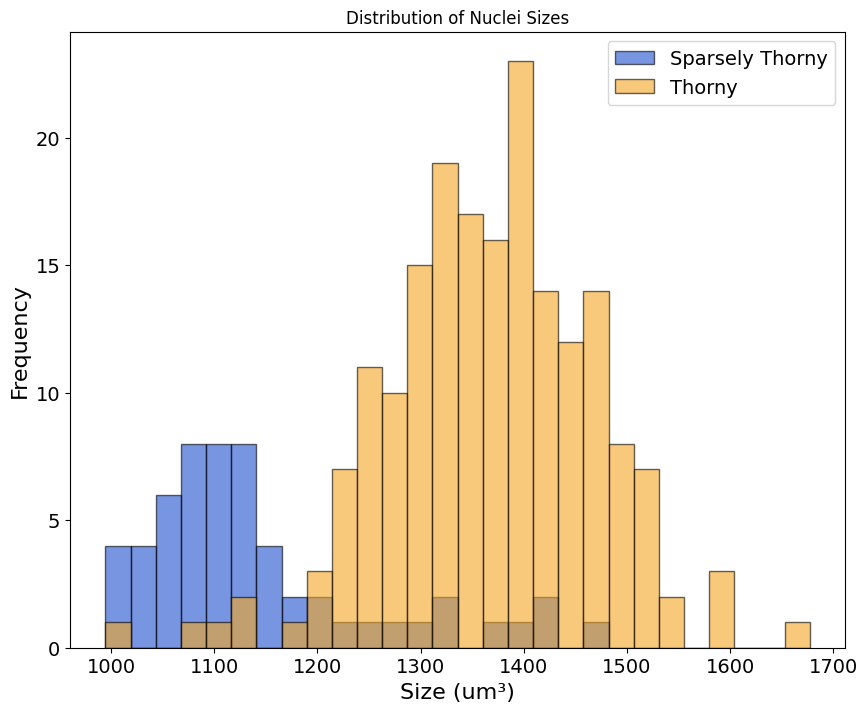

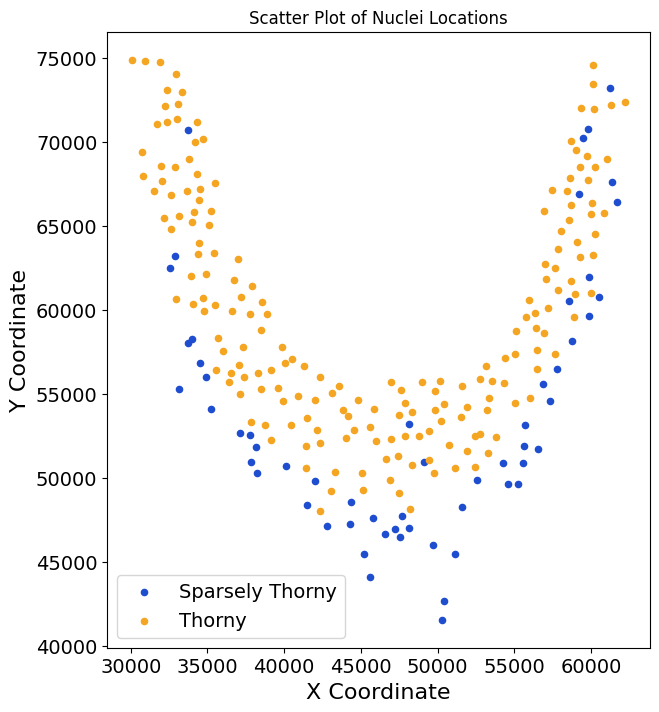

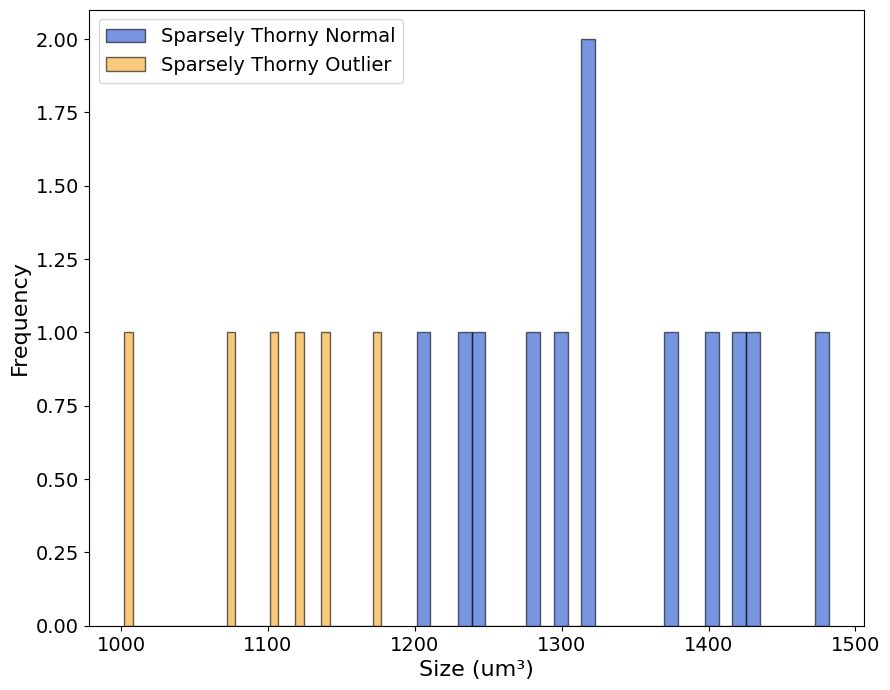

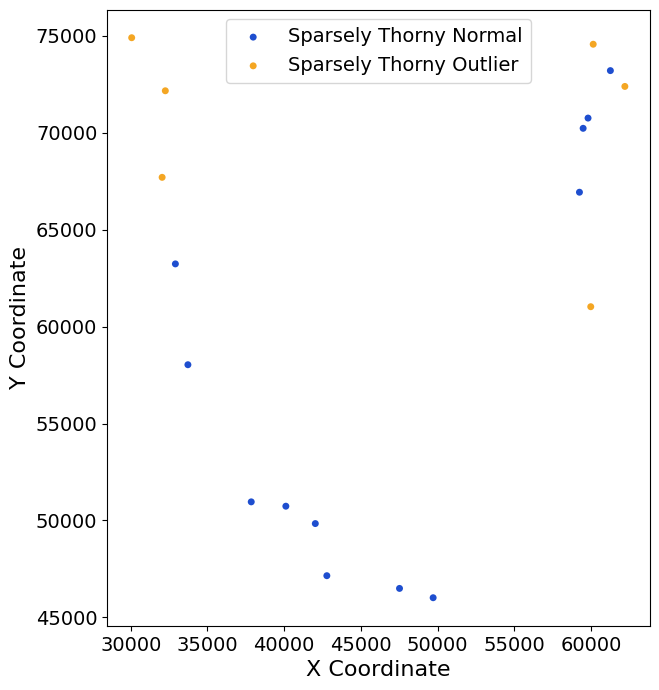

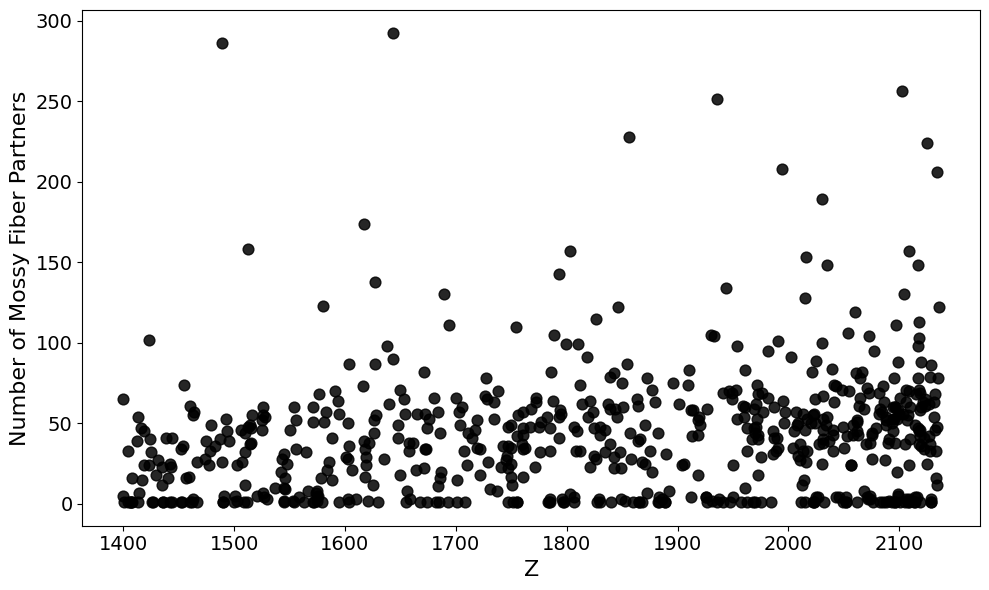

In [19]:
df = pd.read_csv('Apical_pyrs_040125 - MF-pyr.csv')
filter_and_graph_pyr_cells(df, graph=True)